# Project

__Design Specifications__

| Parameter                            | Specification   | Conditions | Unit |
| :----------------                    | :------:        |:--------------|:--------------------: |
| Transimpedance gain (full signal path)                        | $1$         |               | $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)            | $1$             |               | $MHz$ |
| Minimum photodiode current ($i_d$)                  | $2$         |               | $\mu A$ | 
| Photodiode capacitance ($C_d$)              | $150$      |               | $pF$ |
| Closed-loop gain magnitude peaking          | $0$      |               |$dB$|
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)        | $\leq 0.5$           |               | $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize   |               |$mW$ |
| Cost-per-unit (1000 units)          | Optimize       |               |$\$$ |

## Analysis

### 1. Analysis

Transimpedance gain: $ G = 1 / 1e^{-6} = 1M\Omega$

Diode has only shot noise: $e_{nd} = \sqrt{2 q I_d}$

In [28]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

def plot_xlogy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogx(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
k = 1.38e-23                 # Boltzmann constant, J/K
T = 300                      # room temperature (27C) in Kelvin
q = 1.6e-19                  # charge of an electron
kT = k*T

i_ns = np.sqrt(2 * q * 2e-6) # 2uA min current through diode
display(f'i_ns: {i_ns}')



'i_ns: 7.999999999999999e-13'

\begin{equation}
NF = \sqrt{1+\frac{i^2_{n}}{i^2_{ns}}} \\
i_{ns} = 0.8pA\\
NF = 0.5dB\\
.5 dB = 10 \times 10^{\frac{0.5}{10}} = 1.12202\\
1.12202^2 \approx 1.126 \\
1.126 = 1 + \frac{i^2_{n}}{0.64}\\
0.64(1.126 - 1)= i^2_{n}
\end{equation}

In [23]:
i_n_spec = np.sqrt(0.64 * (1.12202**2 - 1))
i_n_tot_spec = i_n_spec * np.sqrt(1e6)

display(f'i_n_spec: {i_n_spec}pA/rtHz i_n_tot_spec: {i_n_tot_spec}pA')

'i_n_spec: 0.4070804385572955pA/rtHz i_n_tot_spec: 407.08043855729545pA'

The following main sources were reviewed for theory and design of TIAs:
- Graeme Book 1995 - discrete bootstrap frontend
- Hobbs Paper 2001 - discrete cascode + bootstrap "no such IC exists"
- Hobbs Book 2009 - same as paper "expensive IC exists"
- Hamamtsu Opto-semiconductor Handbook 2014 - ~dozen IC only circuits, 1 JFET circuit (low cost)

Overall, for moderate bandwidths (1MHz) and large photo diode capacitance (150pf) the literature shows a trend towards simpler designs with either few or no components in the frontend. The following ICs were evaluated for suitability in a design without a discrete frontend:

| Parameter | LF356 | LTC6269 |  ADA4891 | Unit |
| :----------------:  | :----------------: | :----------------: | :----------------: | :---: |
| $i_n$ | f=1kHz, V_C=15V, 10 | f=100kHz, V_C=2.75V, 5.5 | ? | fA |
| $e_n$ | f=1kHz, V_C=15V, 12 | f=1MHz, V_C=2.75V, 4.3 | f=1MHz, V_C=3V, 9 | nV/rtHz |
| $f_T$ | 5 | 500 | V_C=3.3V 190 | MHz |
| $C_{in}$| 3 | .45 | 3.2 | pF|
| Current Supply | 75 | 51 | 14 | mW |
| price / 1000 | 1 Channel, .9 | 2 Channel, 7 | 2 Channel, 1.7 | $ |

The Texas Instruments LF356 is proposed by Hobbs 2001. The proposed design relies on a discrete frontend implementing a bootstrap and a cascode component with a single opamp. The Analog LTC6269 was evaluated in the proof of concept stage of the project and a single IC solution was proposed in the presentation of the project. Lastly, a cheaper alternative, the ADA4891 is presented.

In [165]:
def analyze(C_D, C_f, R_f, e_namp, i_namp, f_T, C_filter, R_filter, R_1, R_2):
    f = np.linspace(1, 10**9, 10**6)
    s = np.multiply(2*np.pi, f)

    zeta = 1 / np.sqrt(2)
    omega_u = 2 * np.pi * f_T
    omega_0_2 = omega_u / (R_f*C_D)
    omega_0 = np.sqrt(omega_0_2)

    tf_tia_mag = R_f * omega_0_2 / np.sqrt( (s*np.sqrt(2)*omega_0)**2 + (omega_0_2-s**2)**2)
    tf_filter_mag = 1 / np.sqrt((s*R_filter*C_filter)**2 + 1)
    tf_noninv_mag = 1 + R_2 / R_1 # assuming ideal opamp
    tf_amp_mag = tf_tia_mag * tf_filter_mag * tf_noninv_mag
    
    #plot_xlogy(f, tf_amp_mag * 2e-6, "frequency", "V/uA")
    tf_amp_db = 20 * np.log10(tf_amp_mag)
    plot_xlogy(f, tf_amp_db, "frequency", "dB")
    display(f'dB at 1MHz: {tf_amp_db[1000]}')
    
    i_tia_e_na = e_namp * s * C_D
    e_tia_na = i_tia_e_na * tf_tia_mag

    e_nRf2 = 4 * kT * R_f
    e_nRf = np.sqrt(e_nRf2)
    e_tia_nRf = (e_nRf/R_f) * tf_tia_mag

    e_tia = np.sqrt(e_tia_na**2 + e_tia_nRf**2)
    
    plot_xlogy(f, e_tia, "frequency", "e_tia")
    x = np.argmax(e_tia)
    display(f'TIA noise peak at: {f[x]} mag: {e_tia[x]}')
    
    e_nRfilter = np.sqrt(4 * kT * R_filter) * tf_noninv_mag
    e_nR2 = np.sqrt(4 * kT * R_2)
    e_nR1 = np.sqrt(4 * kT * R_1) * tf_noninv_mag

    R_1_p_R_2 = R_1 * R_2 / (R_1 + R_2)
    e_i_namp = i_namp * R_1_p_R_2 * tf_noninv_mag
    e_e_namp = e_namp * tf_noninv_mag

    e_tot = np.sqrt((e_tia * tf_filter_mag * tf_noninv_mag) ** 2 + e_nRfilter**2 + e_nR2**2 + e_nR1**2 + e_i_namp**2 + e_e_namp**2)
    
    plot_xlogy(f, e_tot, "frequency", "e_tot")
    x = np.argmax(e_tot)
    f[x],e_tot[x]
    
    e_tot_int = np.trapz(e_tot)
    i_tot_int_input = e_tot_int / 1e9
    i_ns_tot =  0.8e-12 * np.sqrt(1e6)
    
    
    NF = 10*np.log10(np.sqrt(1 + (i_tot_int_input**2) / (i_ns_tot**2)))
    
    display(f'Structure noise peak at: {f[x]} mag: {e_tot[x]}')
    display(f'integrated input noise: {i_tot_int_input} Amp NF: {NF} dB')
    

In [169]:
C_D = 150e-12 # pF

C_f = 0.68e-12 # pF \approx 0
R_f = 240e3 # kOhm

# LTC6269
e_namp_ltc = 4.3e-9 # nV
i_namp_ltc = 5.3e-15 # fA
f_T_ltc = 500e6 # MHz

# ADA4891
e_namp_ada = 9e-9 # nV
i_namp_ada = 15e-15 # fA conservative estimate since no info in data sheet
f_T_ada = 190e6 # MHz

C_filter = 1.5e-9 # pF
R_filter = 100 # Ohm

R_1 = 510 # Ohm
R_2 = 1.8e3 # kOhm

'dB at 1MHz: 117.1557878965859'

'TIA noise peak at: 1485002.4835164833 mag: 1.0235105449358729e-06'

'Structure noise peak at: 1110002.1088911088 mag: 2.956571349305111e-06'

'integrated input noise: 3.323671304917161e-11 Amp NF: 0.003744863020707816 dB'

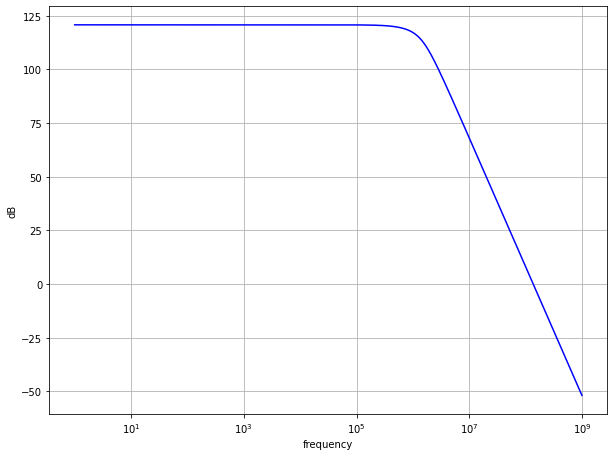

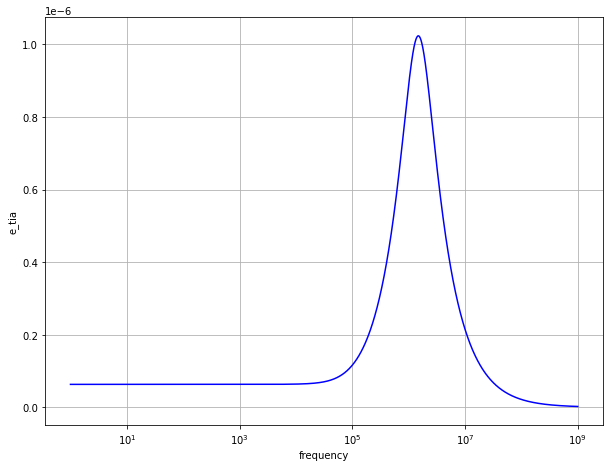

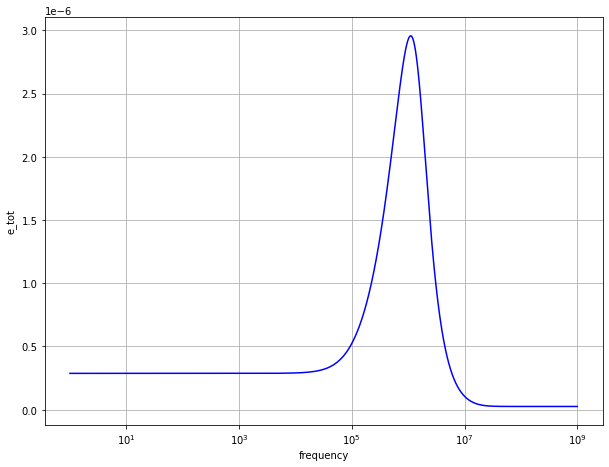

In [170]:
analyze(C_D, 0.68e-12, 240e3, e_namp_ltc, i_namp_ltc, f_T_ltc, 1.5e-9, 100, 510, 1.8e3)

'dB at 1MHz: 117.18021743706343'

'TIA noise peak at: 1245002.2437562437 mag: 9.715371620958196e-07'

'Structure noise peak at: 1061002.05994006 mag: 6.16049317336811e-06'

'integrated input noise: 9.434593427319586e-11 Amp NF: 0.02999286700160468 dB'

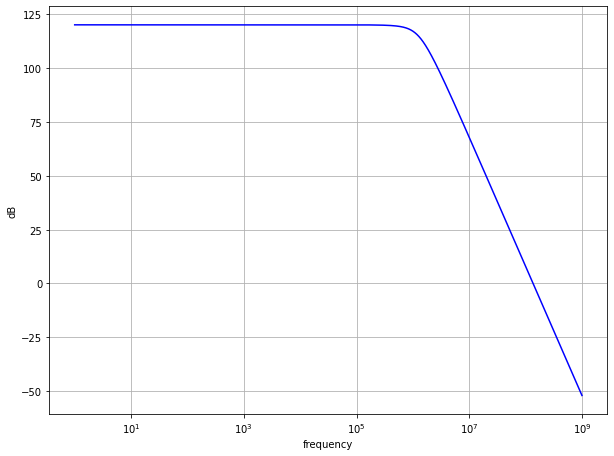

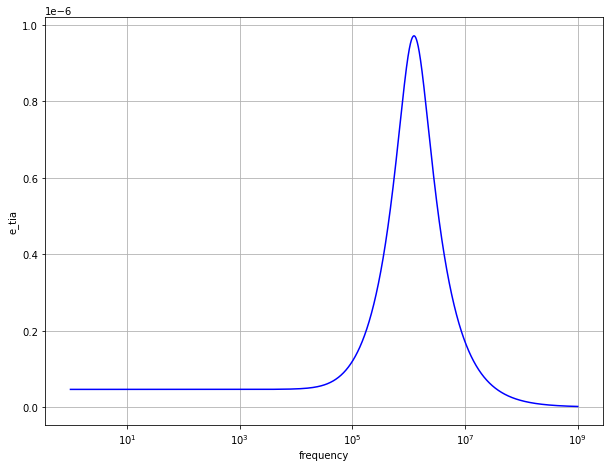

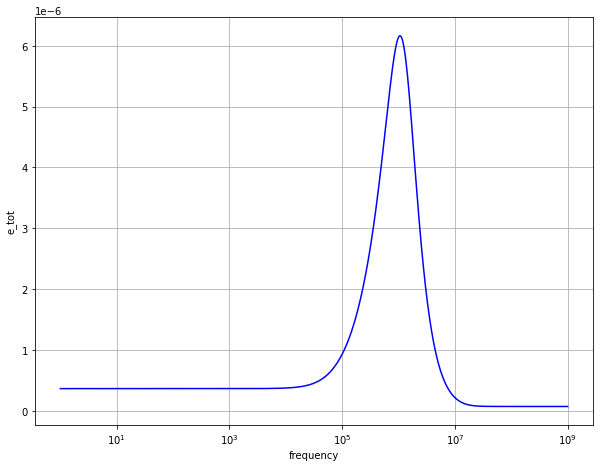

In [171]:
analyze(C_D, 1.6e-12, 130e3, e_namp_ada, i_namp_ada, f_T_ada, 1e-9, 100, 910, 6.2e3)

### 2. Noise

Plots showing the predicted noise and gain/phase as functions of frequency (e.g. using Python).

### 3. Schematic

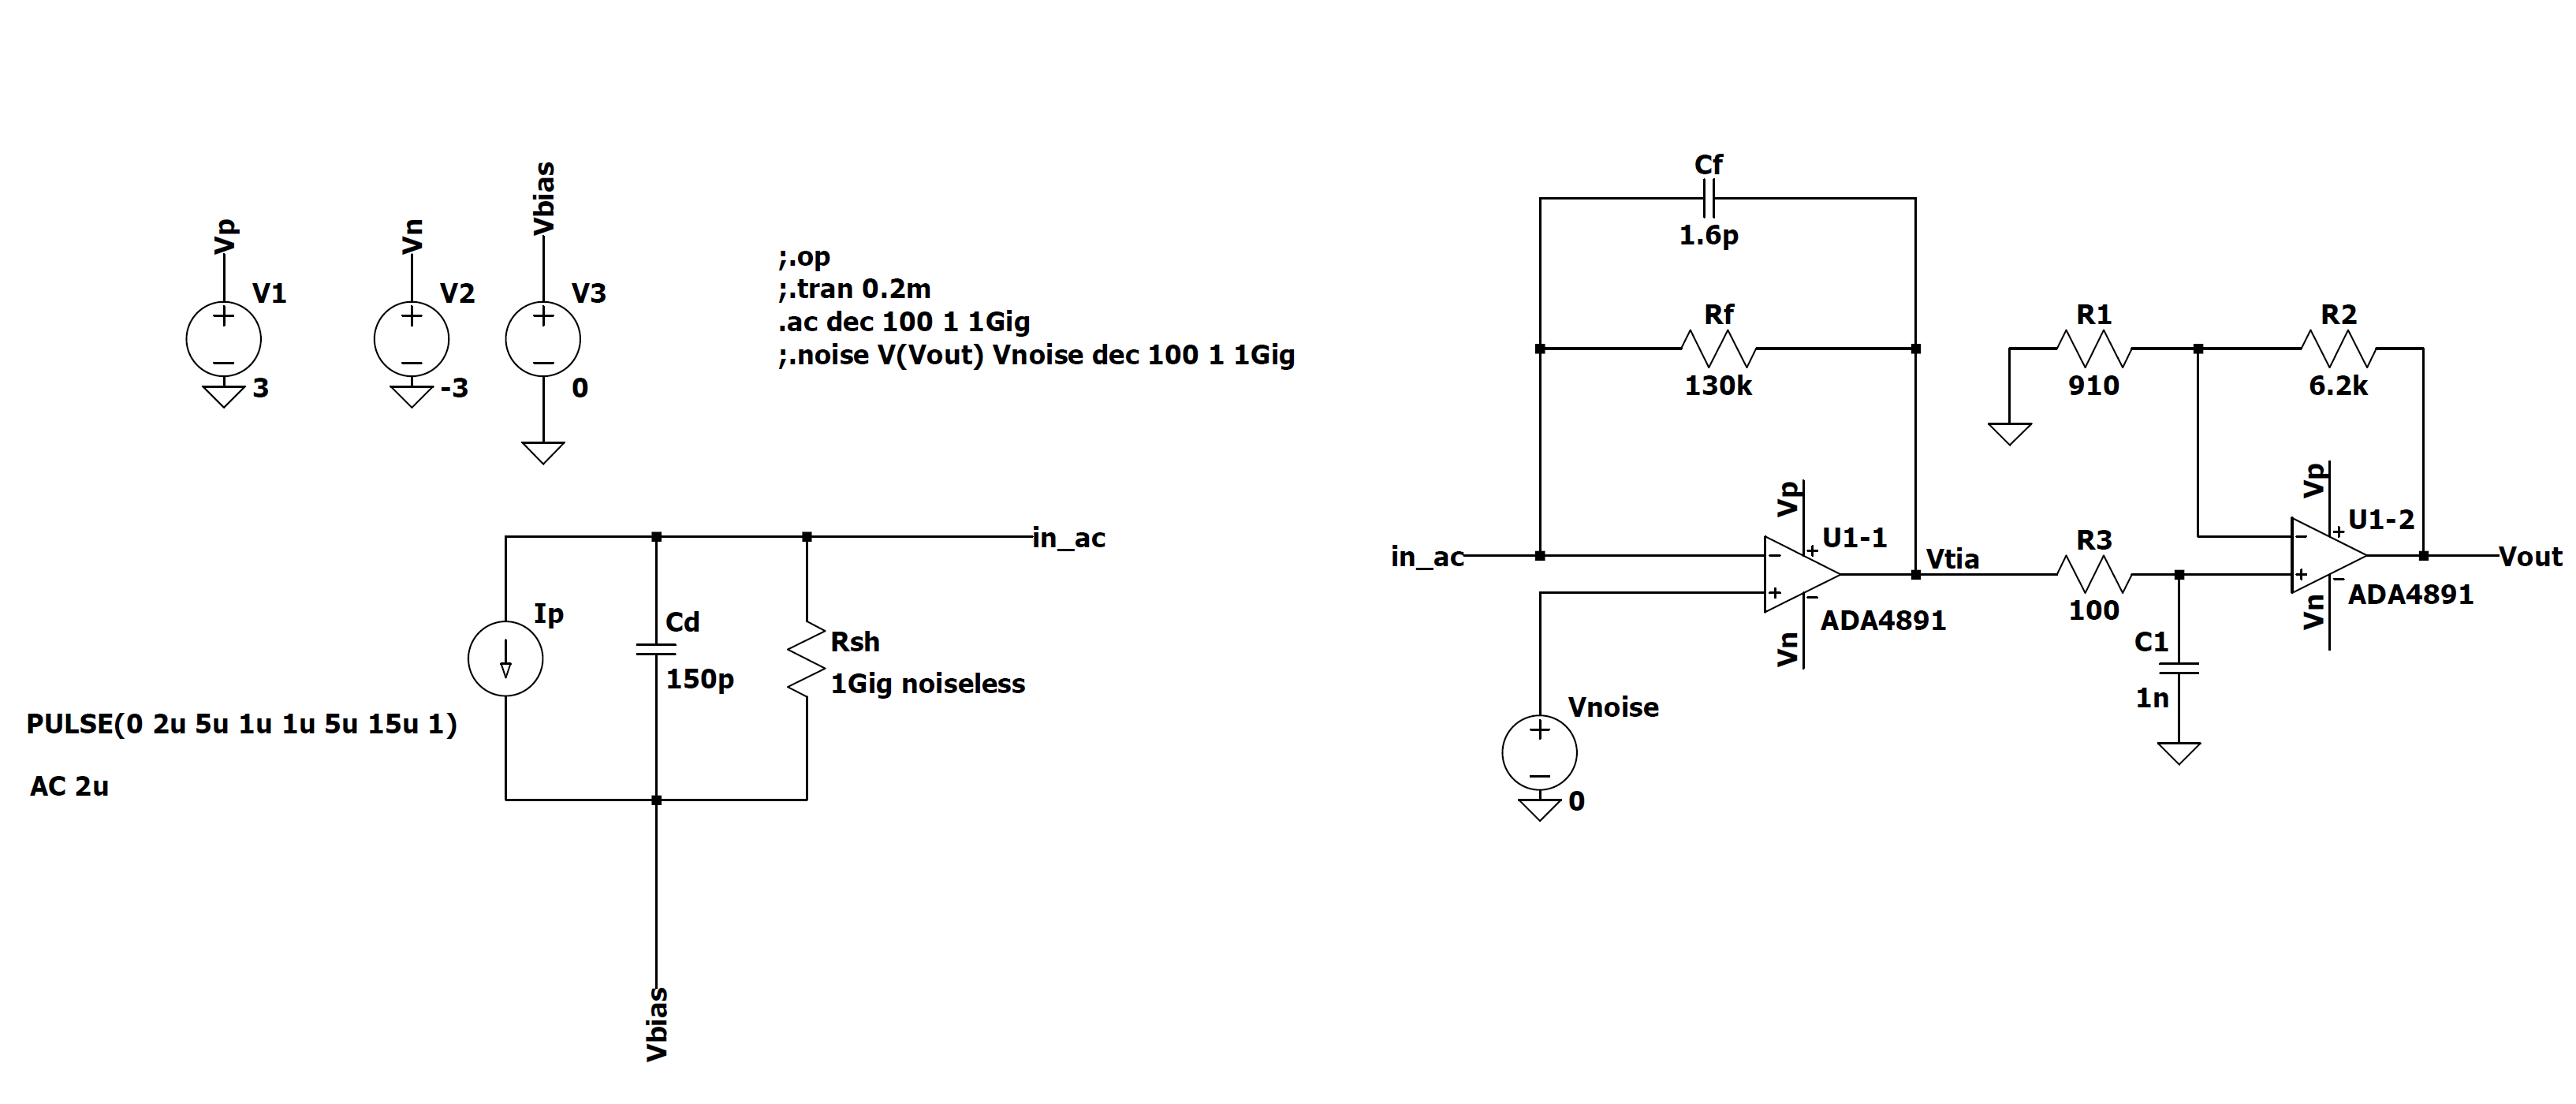

Complete schematic showing the transimpedance stage, any additional gain stages, supply voltages, opamp models, resistor values, and all branch currents and DC node voltages. Indicate the power dissipated by each amplifier by annotating the current through the positive supply pin.

### 4. Noise Contributions

A table summarizing noise contributions from all devices (opamps, transistors, and resistors) and the calculated input-referred noise density and  𝑟𝑚𝑠  noise of each.

### 5. Bill of Materials

A table listing components used, quantity, active power (if applicable) and cost for each item assuming a purchase quantity of 1000, in addition to the total cost and power. Include a link to a Digikey (or equivalent) listing for each component.

## Verification

## 1. Noise Simulation

Noise simulation result showing the input-referred noise noise from 0.01Hz to 100MHz and total  𝑟𝑚𝑠  noise. To plot the input-referred noise, divide the output voltage noise by the DC transimpedance gain value.

## 2. Frequency Response

AC simulation result demonstrating the frequency response (gain and phase) of the entire circuit (0.01Hz to 100MHz), indicating the gain and phase at 1MHz.

## 3. Input Impedance

AC simulation result showing the input impedance as a function of frequency from 0.01Hz to 100MHz.

## 4. Output Step Response

Output step response for an input current step of  0  to  2𝜇𝐴 .

## Discussion

Include a discussion of major design tradeoffs, any insight you gained throughout the design process, and possible suggestions for improving the architecture.